In [ ]:
# Imports necesarios
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Cargar los datos

In [ ]:

data = pd.read_csv("/content/drive/MyDrive/DeepLearning/filtered_data_final.csv", sep=';', index_col=False)
print(data.shape)
data.head()

(3131, 72)


,id,listing_url,scrape_id,last_scraped,source,picture_url,host_id,host_url,host_name,host_since,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3781,https://www.airbnb.com/rooms/3781,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/24670/b2de044...,4804,https://www.airbnb.com/users/show/4804,Frank,2008-12-03,...,4.96,4.88,4.92,NaN,f,1,1,0,0,0.23
1,5506,https://www.airbnb.com/rooms/5506,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,...,4.89,4.55,4.75,STR-490093,f,10,10,0,0,0.68
2,6695,https://www.airbnb.com/rooms/6695,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,...,4.95,4.51,4.71,STR-491702,f,10,10,0,0,0.73
3,8789,https://www.airbnb.com/rooms/8789,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,26988,https://www.airbnb.com/users/show/26988,Anne,2009-07-22,...,4.96,4.96,4.56,NaN,f,9,9,0,0,0.24
4,10813,https://www.airbnb.com/rooms/10813,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/20b5b9c9-e1f4...,38997,https://www.airbnb.com/users/show/38997,Michelle,2009-09-16,...,5.00,5.00,4.80,NaN,f,11,11,0,0,0.09


# 2. Dividir en train, validation y test

In [ ]:
train_val, test = train_test_split(data, test_size=0.2, random_state=42)

# Dividir train+validation en train y validation
train, validation = train_test_split(train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.20 del dataset original
print(train.shape)
print(validation.shape)
print(test.shape)

(1878, 72)
(626, 72)
(627, 72)


# 3. Aplicar transformaciones y limpieza, teniendo en cuenta que se tomarán los calclulos de train para aplicar a validacion y test

Calcular los puntos de corte para crear 3 categorías usando solo el conjunto de entrenamiento


Distribución para el Conjunto de Entrenamiento:
price_group_balanced
0    639
1    619
2    620
Name: count, dtype: int64

Porcentajes:
price_group_balanced
0    34.025559
1    32.960596
2    33.013845
Name: proportion, dtype: float64


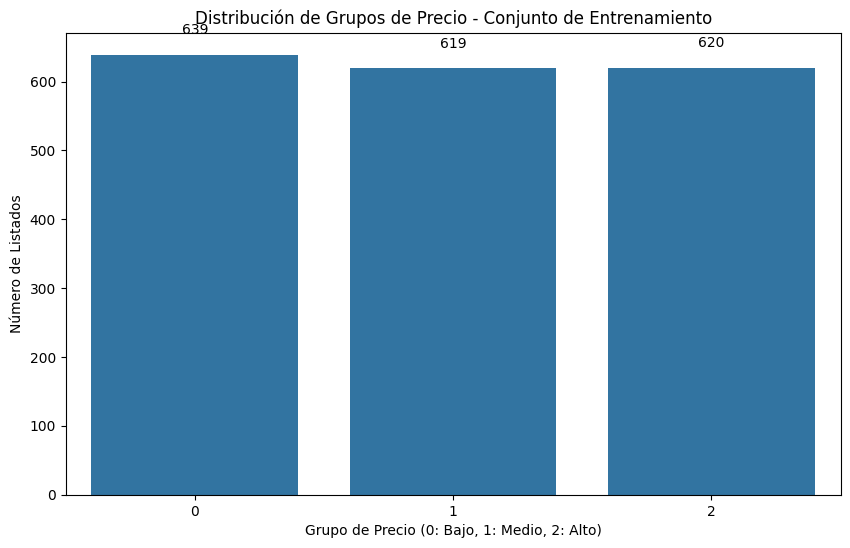


Rangos de precios por categoría - Conjunto de Entrenamiento:
                        min      max
price_group_balanced                
0                      20.0     88.0
1                      89.0    163.0
2                     164.0  10000.0


In [ ]:
q34, q67 = np.percentile(train['price'], [34, 67])

def categorize_price_balanced(price):
    if price < q34:
        return 0  # Bajo
    elif q34 <= price < q67:
        return 1  # Medio
    else:
        return 2  # Alto

# Aplicar la categorización a todos los conjuntos
for dataset in [train, validation, test]:
    dataset['price_group_balanced'] = dataset['price'].apply(categorize_price_balanced)

# Mostrar distribución solo para el conjunto de entrenamiento
print("\nDistribución para el Conjunto de Entrenamiento:")
print(train['price_group_balanced'].value_counts().sort_index())
print("\nPorcentajes:")
print(train['price_group_balanced'].value_counts(normalize=True).sort_index() * 100)

plt.figure(figsize=(10, 6))
sns.countplot(x='price_group_balanced', data=train, order=[0, 1, 2])
plt.title('Distribución de Grupos de Precio - Conjunto de Entrenamiento')
plt.xlabel('Grupo de Precio (0: Bajo, 1: Medio, 2: Alto)')
plt.ylabel('Número de Listados')

for i, v in enumerate(train['price_group_balanced'].value_counts().sort_index()):
    plt.text(i, v + 30, str(v), ha='center')

plt.show()

# Mostrar los rangos de precios para cada categoría solo en el conjunto de entrenamiento
print("\nRangos de precios por categoría - Conjunto de Entrenamiento:")
print(train.groupby('price_group_balanced')['price'].agg(['min', 'max']))

In [ ]:
def extract_bathrooms(text):
    if pd.isna(text):
        return np.nan
    if 'half-bath' in text.lower():
        return 0.5
    try:
        return float(text.split()[0])
    except:
        return np.nan

# Aplicar la función a train, validation y test
for dataset in [train, validation, test]:
    dataset['bathrooms'] = dataset['bathrooms_text'].apply(extract_bathrooms)

Eliminaremos las columnas que no son relevantes para la predicción del precio, que no tienen datos o que podrían causar data leakage.

In [ ]:
columns_to_drop = [
    'id', 'listing_url', 'scrape_id', 'picture_url', 'host_id', 'host_url',
    'host_thumbnail_url', 'host_picture_url', 'last_scraped', 'source',
    'calendar_last_scraped', 'host_name', 'host_about', 'host_location',
    'host_neighbourhood', 'neighbourhood_group_cleansed', 'bathrooms_text',
    'bedrooms', 'calendar_updated', 'number_of_reviews', 'number_of_reviews_ltm',
    'number_of_reviews_l30d', 'first_review', 'last_review', 'reviews_per_month',
    'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'
]

# Eliminar columnas de train, validation y test
train_cleaned = train.drop(columns=columns_to_drop)
validation_cleaned = validation.drop(columns=columns_to_drop)
test_cleaned = test.drop(columns=columns_to_drop)

# Verificar la forma del nuevo DataFrame
print("\nForma del DataFrame limpio:")
print(train_cleaned.shape)



Forma del DataFrame limpio:
(1878, 44)


(1878, 28)


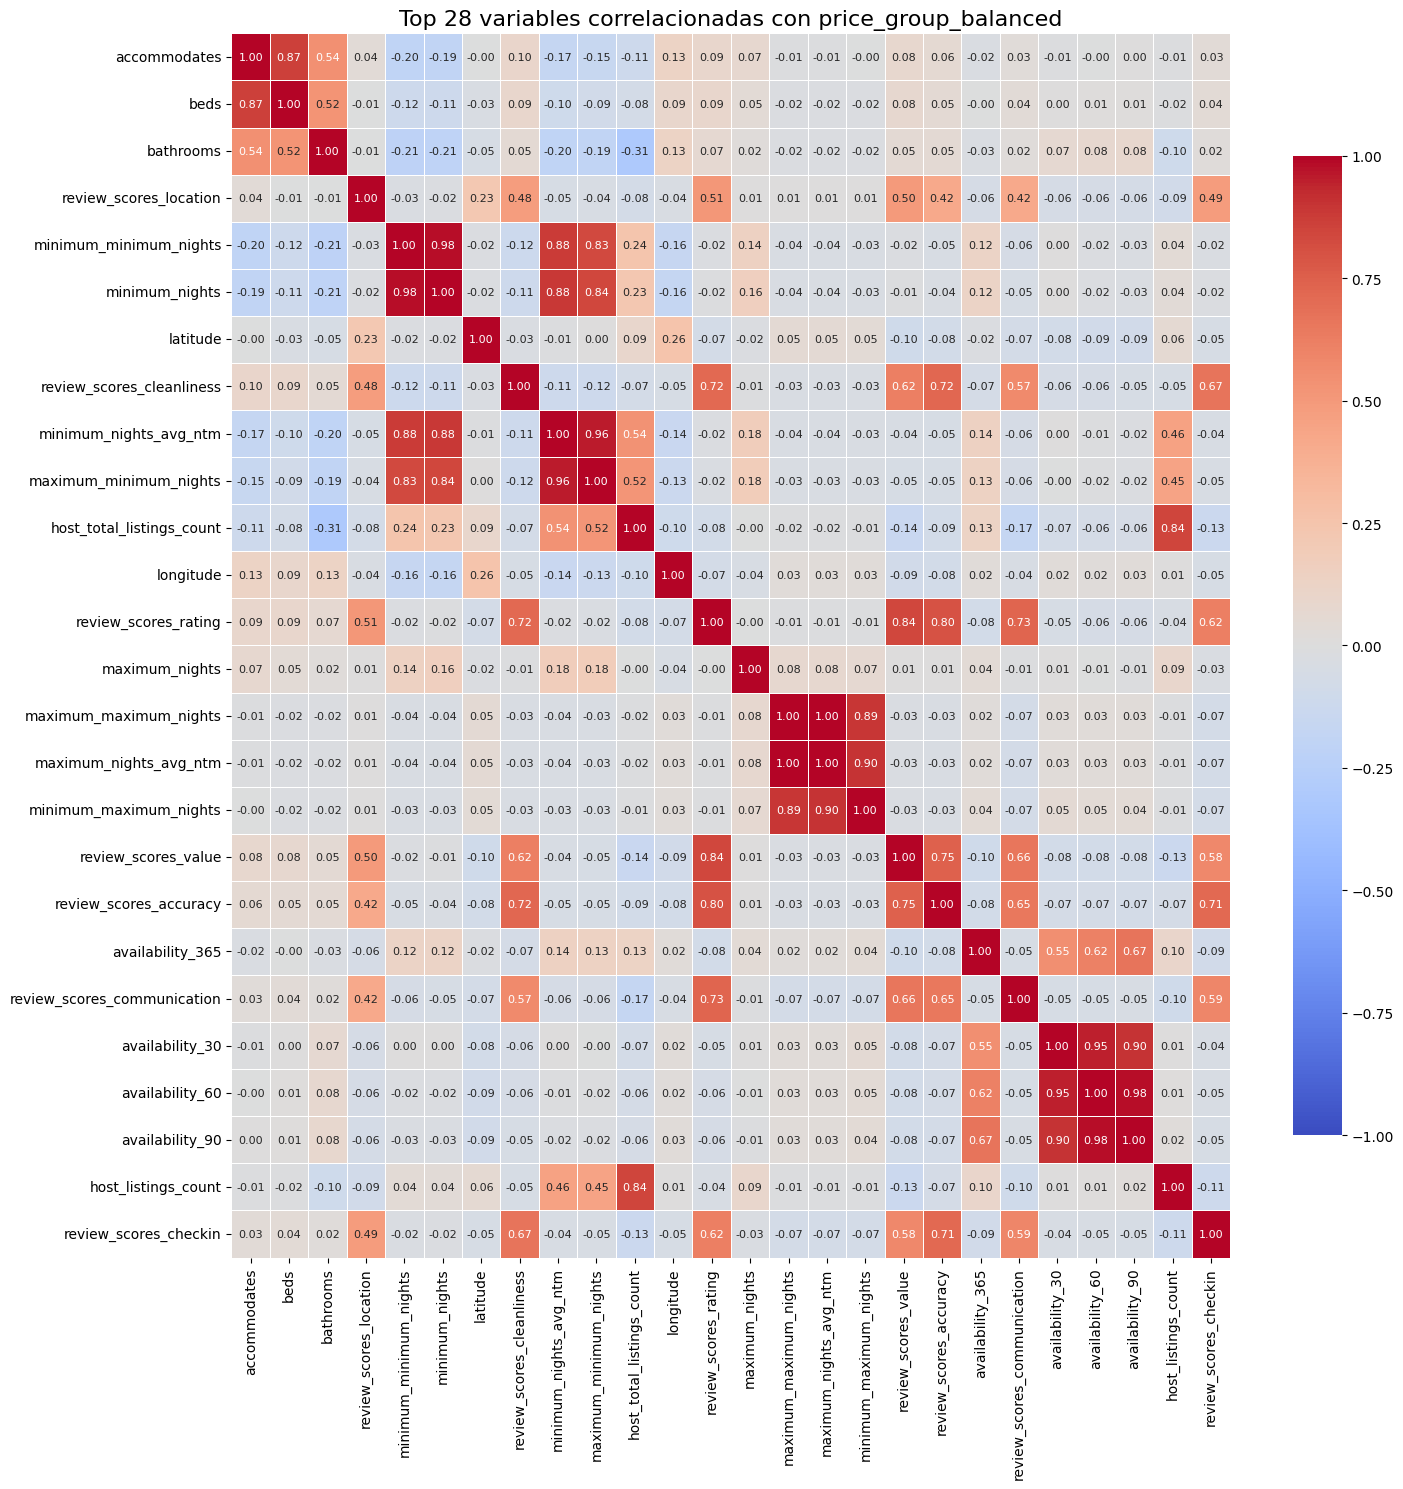

Columnas ordenadas por grado de influencia en el price_group_balanced:
price_group_balanced           1.000000
accommodates                   0.584956
beds                           0.464053
price                          0.334755
bathrooms                      0.331673
review_scores_location         0.184776
minimum_minimum_nights         0.175605
minimum_nights                 0.169281
latitude                       0.161743
review_scores_cleanliness      0.139123
minimum_nights_avg_ntm         0.136173
maximum_minimum_nights         0.126528
host_total_listings_count      0.118250
longitude                      0.118188
review_scores_rating           0.110994
maximum_nights                 0.102456
maximum_maximum_nights         0.063747
maximum_nights_avg_ntm         0.063741
minimum_maximum_nights         0.057002
review_scores_value            0.045428
review_scores_accuracy         0.043639
availability_365               0.036610
review_scores_communication    0.026127
availabil

In [ ]:
numeric = train_cleaned.select_dtypes(include=[np.number])
print(numeric.shape)
correlation_matrix = numeric.corr()
price_correlations = correlation_matrix['price_group_balanced']

# Obtener las correlaciones con 'price_group_balanced'
price_group_correlations = correlation_matrix['price_group_balanced'].abs().sort_values(ascending=False)

# Seleccionar las top N variables más correlacionadas (excluyendo price y price_group_balanced)
N = 28  # Puedes ajustar este número según necesites
top_correlated = price_group_correlations.drop(['price', 'price_group_balanced']).nlargest(N).index

# Crear una submatriz con las variables más correlacionadas
correlation_subset = correlation_matrix.loc[top_correlated, top_correlated]

# Crear el mapa de calor
plt.figure(figsize=(15, 15))
heatmap=sns.heatmap(correlation_subset,
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            center=0,
            fmt='.2f',
            linewidths=0.5,
            cbar_kws={"shrink": .8},
            annot_kws={"size": 8})

# Ajustar automáticamente el tamaño de la fuente
for text in heatmap.texts:
    text.set_fontsize(8)  # Reducido el tamaño de la fuente

plt.title(f'Top {N} variables correlacionadas con price_group_balanced', fontsize=16)
plt.tight_layout()
plt.show()

# Ordenar por el valor absoluto de la correlación, de mayor a menor
absolute_correlations = price_correlations.abs().sort_values(ascending=False)

# Imprimir las correlaciones
print("Columnas ordenadas por grado de influencia en el price_group_balanced:")
print(absolute_correlations)
# Crear una lista de nombres de columnas ordenadas por influencia
influential_columns = absolute_correlations.index.tolist()

# Crear la cadena de texto en el formato deseado
columns_string = "columnas = ('" + "', '".join(influential_columns) + "')"

# Imprimir el resultado
print(columns_string)

# 4. Preparación de Datos para Modelos de Aprendizaje Automático

In [ ]:
# Función para preparar X e y
def prepare_features_and_target(df):

    feature_columns = ['accommodates', 'beds', 'bathrooms', 'review_scores_location', 'minimum_minimum_nights', 'minimum_nights', 'latitude',
                       'review_scores_cleanliness', 'minimum_nights_avg_ntm', 'maximum_minimum_nights', 'host_total_listings_count', 'longitude',
                       'review_scores_rating', 'maximum_nights', 'maximum_maximum_nights', 'maximum_nights_avg_ntm', 'minimum_maximum_nights',
                       'review_scores_value', 'review_scores_accuracy', 'availability_365', 'review_scores_communication', 'availability_30',
                       'availability_60', 'availability_90', 'host_listings_count', 'review_scores_checkin']

    X = df[feature_columns]
    y = df['price_group_balanced']
    print(X.shape)
    print(y.shape)

    return X, y

# Preparar conjuntos de entrenamiento, validación y prueba
X_train, y_train = prepare_features_and_target(train_cleaned)
X_val, y_val = prepare_features_and_target(validation_cleaned)
X_test, y_test = prepare_features_and_target(test_cleaned)

(1878, 26)
(1878,)
(626, 26)
(626,)
(627, 26)
(627,)


In [ ]:
# Imputar valores faltantes
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Normalización de datos de X
scaler_X = RobustScaler()
X_train_scaled = scaler_X.fit_transform(X_train_imputed)
X_val_scaled = scaler_X.transform(X_val_imputed)
X_test_scaled = scaler_X.transform(X_test_imputed)

# Convertir a arrays de NumPy
X_train_np = X_train_scaled.astype(np.float32)
X_val_np = X_val_scaled.astype(np.float32)
X_test_np = X_test_scaled.astype(np.float32)
y_train_np = y_train.values.astype(np.int32)
y_val_np = y_val.values.astype(np.int32)
y_test_np = y_test.values.astype(np.int32)

In [ ]:
# Crear un diccionario con todos los arrays
data = {
    'X_train': X_train_np,
    'X_val': X_val_np,
    'X_test': X_test_np,
    'y_train': y_train_np,
    'y_val': y_val_np,
    'y_test': y_test_np
}

# Guardar el diccionario en un archivo .npz en la ruta especificada
np.savez('/content/drive/MyDrive/DeepLearning/data_arrays.npz', **data)

# 5. Evaluación y Visualización del Rendimiento del Modelo de Red Neuronal

In [ ]:
def train_network(learning_rate, batch_size, num_epochs):
    # Configurar semillas para reproducibilidad
    np.random.seed(42)
    tf.random.set_seed(42)

    # Definir el modelo
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_np.shape[1],), kernel_regularizer=l2(0.01)),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(3, activation='softmax')  # 3 clases: 0, 1, 2
    ])

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Definir early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Entrenar el modelo
    history = model.fit(X_train_np, y_train_np,
                        validation_data=(X_val_np, y_val_np),
                        epochs=num_epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping],
                        verbose=1)

    # Evaluar el modelo
    train_loss, train_acc = model.evaluate(X_train_np, y_train_np, verbose=0)
    val_loss, val_acc = model.evaluate(X_val_np, y_val_np, verbose=0)
    test_loss, test_acc = model.evaluate(X_test_np, y_test_np, verbose=0)

    print(f"Precisión en entrenamiento: {train_acc:.4f}")
    print(f"Precisión en validación: {val_acc:.4f}")
    print(f"Precisión en prueba: {test_acc:.4f}")

    # Hacer predicciones
    y_pred = model.predict(X_test_np)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Imprimir reporte de clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y_test_np, y_pred_classes))

    # Graficar la historia del entrenamiento
    plt.figure(figsize=(12, 4))

    # Gráfica de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')

    # Añadir cuadro de texto con parámetros
    plt.text(0.05, 0.05, f'Learning Rate: {learning_rate}\nBatch Size: {batch_size}\nÉpocas: {num_epochs}',
             transform=plt.gca().transAxes, fontsize=9,
             verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.title('Pérdida del Modelo')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.ylim(0, 2)  # Ajusta estos valores según sea necesario
    plt.legend()

    # Gráfico de precisión
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')

    # Punto de test
    test_epoch = len(history.history['accuracy']) - 1
    plt.scatter(len(history.history['accuracy']) - 1, test_acc, color='r', label='Test', s=100, zorder=5)

    # Añadir el valor de test_acc al gráfico
    plt.text(test_epoch, test_acc + 0.02, f'{test_acc:.2f}', color='black', fontsize=12,
             horizontalalignment='center')

    # Añadir cuadro de texto con parámetros
    plt.text(0.05, 0.05, f'Learning Rate: {learning_rate}\nBatch Size: {batch_size}\nÉpocas: {num_epochs}',
             transform=plt.gca().transAxes, fontsize=9,
             verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.title('Precisión del Modelo')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.ylim(0, 1)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model  # Retornar el modelo entrenado

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.3701 - loss: 2.0378 - val_accuracy: 0.5319 - val_loss: 1.7177
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5563 - loss: 6.6066 - val_accuracy: 0.5799 - val_loss: 1.4846
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6187 - loss: 1.4039 - val_accuracy: 0.6102 - val_loss: 1.3419
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6452 - loss: 1.2554 - val_accuracy: 0.6230 - val_loss: 1.2351
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6569 - loss: 1.1500 - val_accuracy: 0.6166 - val_loss: 1.1775
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6671 - loss: 1.0897 - val_accuracy: 0.6198 - val_loss: 1.1452
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6676 - loss: 1.0493 - val_accuracy: 0.6198 - val_loss: 1.1220
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6686 - loss: 1.0209 - val_accuracy: 0.6230 - val_loss: 1.

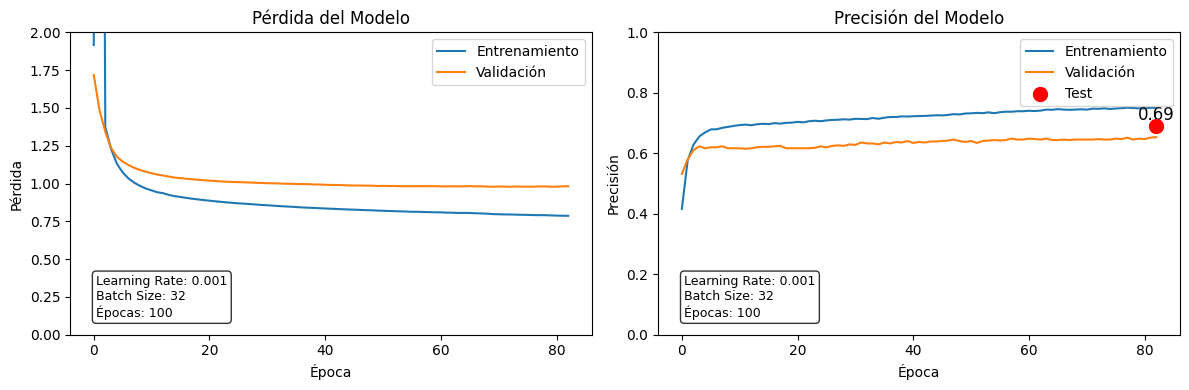

In [ ]:
# Ejemplo de uso:
modelo_entrenado = train_network(learning_rate=0.001, batch_size=32, num_epochs=100)

In [ ]:
modelo_entrenado.summary()
modelo_entrenado.save('/content/drive/MyDrive/DeepLearning/modelo_tabular.h5')
modelo_entrenado.save('/content/drive/MyDrive/DeepLearning/modelo_tabular.keras')

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                     │ (None, 64)                  │           1,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,163 (51.42 KB)

 Trainable params: 4,387 (17.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,776 (34.29 KB)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.5447 - loss: 1009.3102 - val_accuracy: 0.6182 - val_loss: 1.3004
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6487 - loss: 1.2360 - val_accuracy: 0.6214 - val_loss: 1.2096
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6631 - loss: 1.1210 - val_accuracy: 0.6118 - val_loss: 1.1687
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6603 - loss: 1.0810 - val_accuracy: 0.6118 - val_loss: 1.1397
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6654 - loss: 1.0572 - val_accuracy: 0.6070 - val_loss: 1.1448
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6680 - loss: 1.0482 - val_accuracy: 0.6150 - val_loss: 1.1258
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6667 - loss: 1.0348 - val_accuracy: 0.6182 - val_loss: 1.1145
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6738 - loss: 1.0259 - val_accuracy: 0.6166 - val_loss:

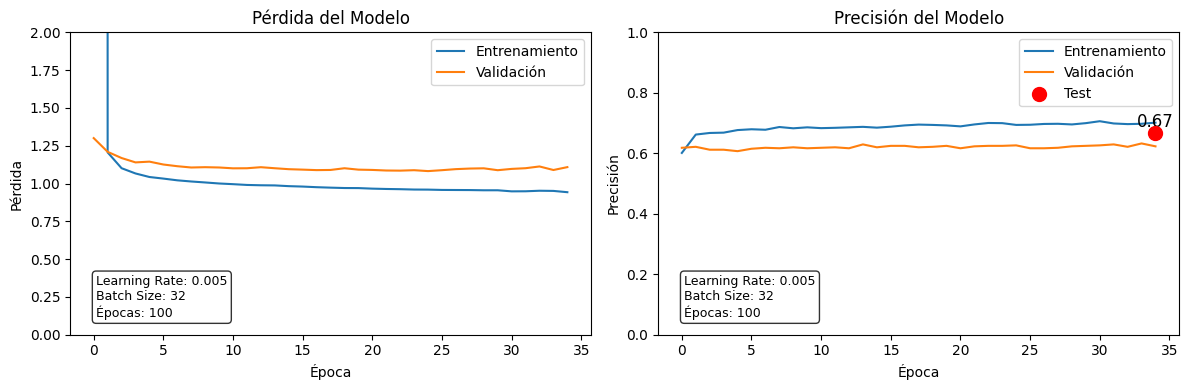

<Sequential name=sequential_11, built=True>

In [ ]:
# Ejemplo de uso:
train_network(learning_rate=0.005, batch_size=32, num_epochs=100)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.5372 - loss: 401.3734 - val_accuracy: 0.5815 - val_loss: 1.2080
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6447 - loss: 1.1090 - val_accuracy: 0.5911 - val_loss: 1.1255
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6632 - loss: 1.0331 - val_accuracy: 0.6022 - val_loss: 1.0953
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6578 - loss: 1.0057 - val_accuracy: 0.6054 - val_loss: 1.1055
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6432 - loss: 0.9892 - val_accuracy: 0.6086 - val_loss: 1.0876
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6619 - loss: 0.9747 - val_accuracy: 0.6038 - val_loss: 1.0711
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6520 - loss: 0.9683 - val_accuracy: 0.5911 - val_loss: 1.0915
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6589 - loss: 0.9698 - val_accuracy: 0.5974 - val_loss: 

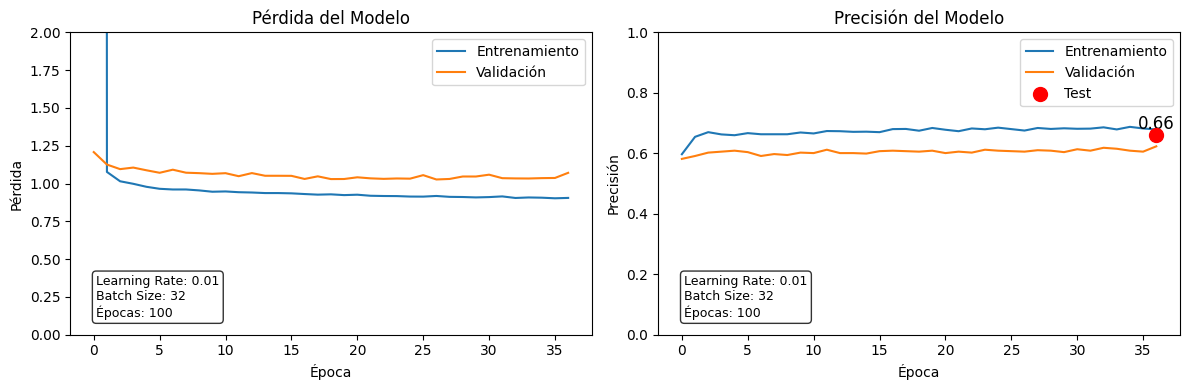

<Sequential name=sequential_12, built=True>

In [ ]:
# Ejemplo de uso:
train_network(learning_rate=0.01, batch_size=32, num_epochs=100)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step - accuracy: 0.4467 - loss: 167.8555 - val_accuracy: 0.4872 - val_loss: 1.6576
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5544 - loss: 1.5367 - val_accuracy: 0.5831 - val_loss: 1.3692
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6205 - loss: 1.2844 - val_accuracy: 0.6006 - val_loss: 1.2450
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6512 - loss: 1.1564 - val_accuracy: 0.6070 - val_loss: 1.1793
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6607 - loss: 1.0881 - val_accuracy: 0.6102 - val_loss: 1.1515
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6750 - loss: 1.0390 - val_accuracy: 0.6086 - val_loss: 1.1244
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6834 - loss: 1.0074 - val_accuracy: 0.6086 - val_loss: 1.1022
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6748 - loss: 0.9943 - val_accuracy: 0.6246 - val_loss: 1.0963
Epoch 9/

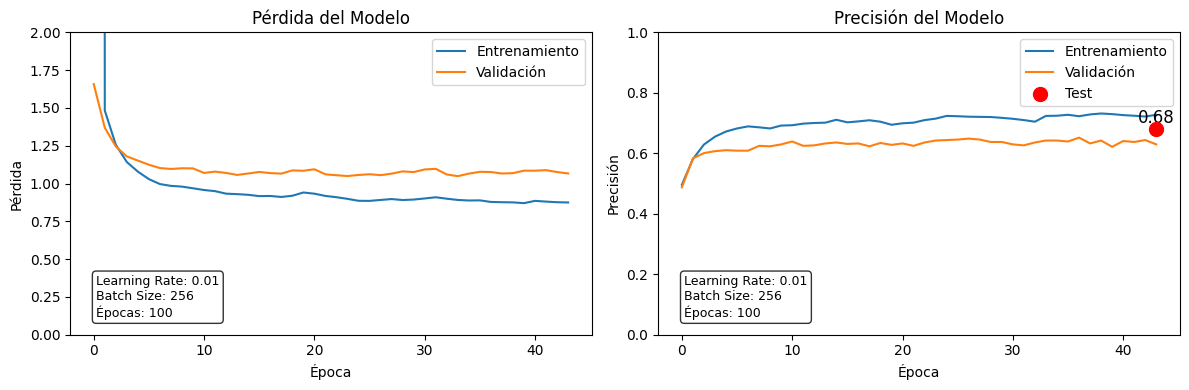

<Sequential name=sequential_13, built=True>

In [ ]:
# Ejemplo de uso:
train_network(learning_rate=0.01, batch_size=256, num_epochs=100)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 639ms/step - accuracy: 0.3892 - loss: 395.6520 - val_accuracy: 0.5064 - val_loss: 1.7443
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5280 - loss: 1.6682 - val_accuracy: 0.5671 - val_loss: 1.5357
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5882 - loss: 1.4481 - val_accuracy: 0.5895 - val_loss: 1.3776
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6218 - loss: 1.2848 - val_accuracy: 0.5847 - val_loss: 1.2711
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6516 - loss: 1.1800 - val_accuracy: 0.5990 - val_loss: 1.2051
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6556 - loss: 1.1107 - val_accuracy: 0.6054 - val_loss: 1.1699
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6682 - loss: 1.0630 - val_accuracy: 0.6214 - val_loss: 1.1330
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6784 - loss: 1.0296 - val_accuracy: 0.6118 - val_loss: 1.1153
E

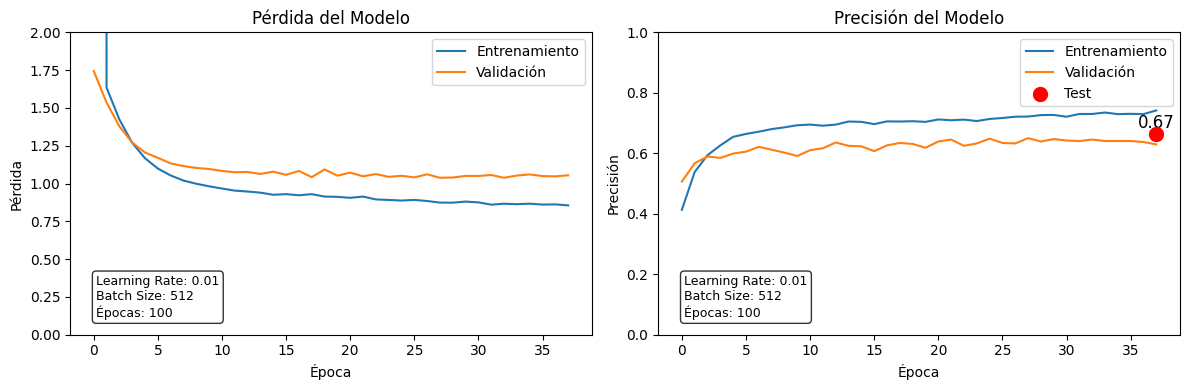

<Sequential name=sequential_14, built=True>

In [ ]:
# Ejemplo de uso:
train_network(learning_rate=0.01, batch_size=512, num_epochs=100)